[View in Colaboratory](https://colab.research.google.com/github/Rblivingstone/iMaterialist_Kaggle_competition/blob/master/notebook.ipynb)

In [2]:
!pip install kaggle
import keras
import pandas as pd
import numpy as np

Looking in indexes: https://pypi.org/simple, https://legacy.pypi.org/simple
  Running setup.py bdist_wheel for kaggle ... - done
  Stored in directory: /content/.cache/pip/wheels/dc/03/02/372e828042d91dc9d96c6d5eab5b14591790dafe70600b7309
Successfully built kaggle


In [3]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)
 



Download 100%.


In [4]:
!kaggle competitions download -c imaterialist-challenge-fashion-2018 -w

test.json.zip: Downloaded 644KB of 644KB
validation.json.zip: Downloaded 296KB of 296KB
train.json.zip: Downloaded 26MB of 26MB
sample_submission.csv.zip: Downloaded 477KB of 477KB


In [0]:
from shutil import unpack_archive
unpack_archive('train.json.zip')


In [6]:
import json
print('okay')
json_data=open('train.json').read()
print('cool')
data = json.loads(json_data)
print('done')
!rm train.json
!rm test.json.zip
!rm validation.json.zip
!rm train.json.zip
!rm sample_submission.csv.zip
print('removed extraneous data')

okay
cool
done
removed extraneous data


In [0]:
urls = [obj['url'] for obj in data['images']]
ids = [obj['imageId'] for obj in data['images']]

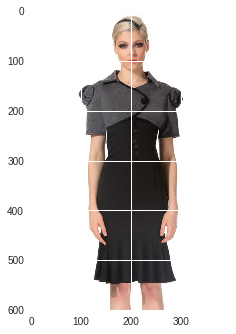

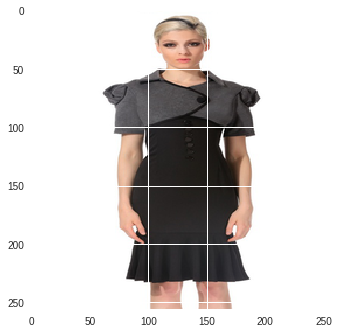

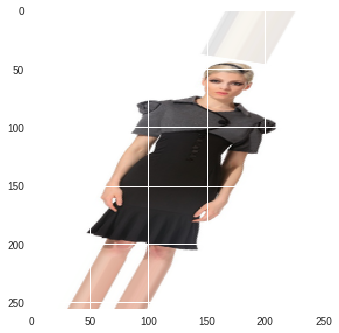

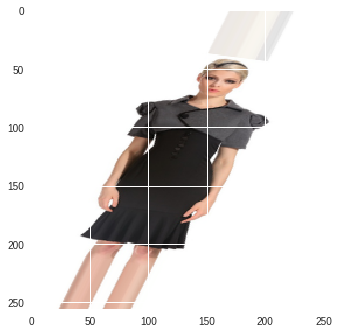

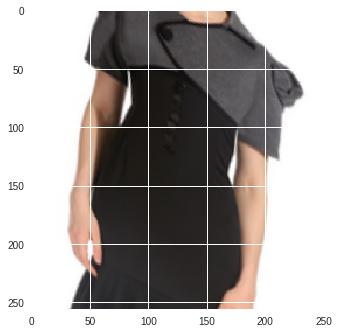

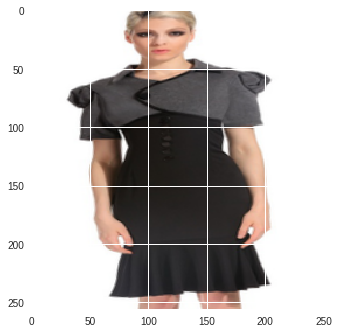

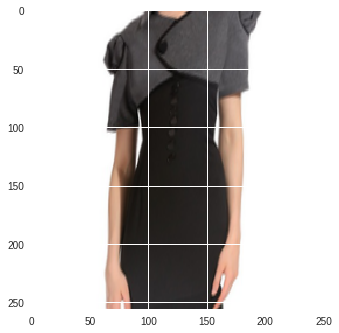

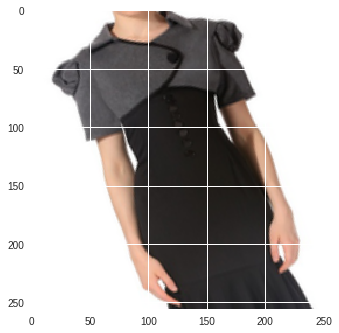

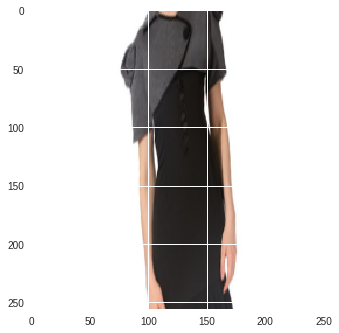

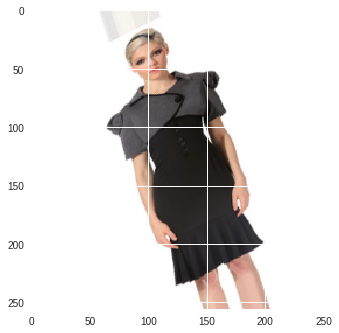

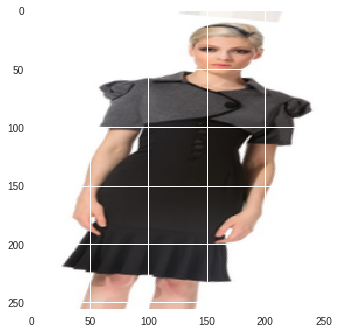

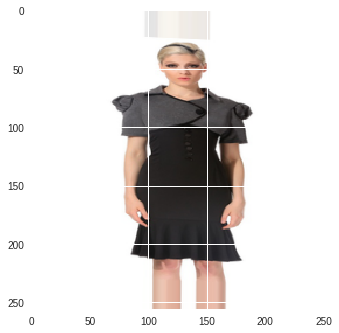

In [8]:
from urllib.request import urlopen	
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
#import StringIO
size=(256,256)
idg = ImageDataGenerator(rescale=1./255,
                        horizontal_flip=True,
                        zoom_range=0.5,
                        shear_range=15,
                        rotation_range=25
                        )
img_file = urlopen(urls[137])
#im_str = StringIO(img_file.read())
I = np.asarray(Image.open(img_file))
plt.imshow(I)
plt.show()

img_file = urlopen(urls[137])
#im_str = StringIO(img_file.read())
im = Image.open(img_file)
im2 = im.resize(size, Image.ANTIALIAS)
im2.thumbnail(size, Image.ANTIALIAS)
I = np.asarray(im2)
plt.imshow(I)
plt.show()
idg_flow = idg.flow(I.reshape(1,256,256,3), batch_size=32)
for i in range(10):
  plt.imshow(idg_flow.next()[0])
  plt.show()

In [9]:
import numpy as np
output = []
for dat in data['annotations']:
  temp = [0]*228
  for obj in dat['labelId']:
    temp[int(obj)-1] = 1
  output.append(temp)
depvar = np.array(output)
print(depvar)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [0]:
cweights = {}
cw = 1/(np.sum(depvar,axis=0)/np.sum(depvar))
for i in range(len(depvar[0])):
  cweights[i+1] = cw[i]
cweights[0] = 1
data = [obj['labelId'] for obj in data['annotations']]

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten
from keras.optimizers import SGD,Adamax
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

def discriminator_model():
    model = Sequential()
    model.add(
            Conv2D(64, (5, 5),
            padding='same',
            input_shape=(256, 256, 3))
            )
    #model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(Dropout(0.1))
    model.add(Conv2D(128, (5, 5)))
    #model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(Dropout(0.1))
    model.add(Conv2D(64, (5, 5)))
    #model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(Dropout(0.1))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dropout(0.1))
    #model.add(Activation('relu'))
    model.add(Dense(512))
    model.add(Dropout(0.1))
    #model.add(Activation('relu'))
    model.add(Dense(228))
    #model.add(Activation('sigmoid'))
    print(model)
    return model
  


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
from keras.models import load_model
model = drive.CreateFile({'id': '1EHMbz_Vk7KTW1U4oMzoPUr4xGyZMN0WG'})
model.GetContentFile('model.h5')
d = load_model('model.h5')
#d = load_model('model.h5')
def generate_labels(array):
  output = []
  for row in array:
    temp = []
    for i in range(228):
      if row[i]>=0.5:
        temp.append(i+1)
    output.append(temp)
  return(output)

def convert_pic_to_data(url):
  try:
    img_file = urlopen(url)
    im = Image.open(img_file)
    
  except:
    output = [0]*(256*256*3)
    output = np.array(output).reshape(1,256,256,3)
    return(output)
    
  im2 = im.resize(size, Image.ANTIALIAS)
  im2.thumbnail(size, Image.ANTIALIAS)
  output = np.asarray(im2)
  return(output.reshape(1,256,256,3))

def label_maker(lookup_range=(0,1)):
  output = []
  for i in range(lookup_range[1]-lookup_range[0]):
    output.append({'id':i+1,'labels':generate_labels(d.predict(convert_pic_to_data(urls[lookup_range[0]+i])))})
  return(output)

#print(label_maker((5,10)))

0
Epoch 1/5
640/640 [==============================] - 4s 6ms/step - loss: 3723.5647
Epoch 2/5
640/640 [==============================] - 4s 6ms/step - loss: 3073.2212
Epoch 3/5
640/640 [==============================] - 4s 6ms/step - loss: 2762.6123
Epoch 4/5
640/640 [==============================] - 4s 6ms/step - loss: 2442.8354
Epoch 5/5
640/640 [==============================] - 4s 6ms/step - loss: 2284.5996


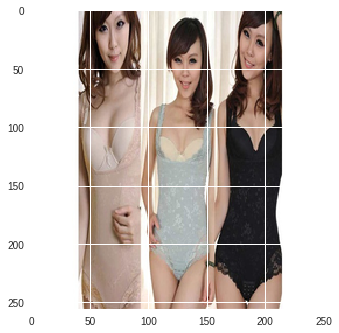

[[4, 13, 17, 20, 23, 27, 28, 33, 34, 35, 36, 44, 48, 49, 50, 52, 53, 62, 64, 65, 69, 82, 84, 87, 89, 93, 96, 98, 102, 103, 105, 106, 109, 113, 116, 117, 132, 137, 145, 146, 151, 153, 154, 155, 158, 159, 164, 170, 171, 174, 175, 186, 189, 190, 203, 204, 208, 214, 222, 226]]
[20, 51, 106, 180, 186]
---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------
[(214, 85.9462), (222, 81.45581), (53, 69.42643), (190, 66.69758), (164, 63.609173), (113, 61.891792), (62, 29.139473), (82, 21.02795), (171, 13.558107), (175, 13.389278), (226, 11.608419), (117, 11.005269), (154, 10.479296), (105, 9.507283), (153, 7.1913834), (106, 4.929192), (155, 4.017966), (116, 3.8184276), (137, 3.5347974), (20, 2.6784387), (204, 2.2722304), (49, 1.6993828), (28, 1.6475508), (98, 1.4331294), (33, 1.3579711), (170, 1.342241), (87, 1.1286843), (189, 1.1242197), (69, 1

In [0]:
from google.colab import files
from keras.models import load_model



model = drive.CreateFile({'id': '1EHMbz_Vk7KTW1U4oMzoPUr4xGyZMN0WG'})
model.GetContentFile('model.h5')
model2 = drive.CreateFile({'id':'1fvJiLoyw96cFmAJmbG41mAs2ZXzLb35S'})
model2.GetContentFile('model_weights.h5')
d = load_model('model.h5')
#d = discriminator_model()
d.load_weights('model_weights.h5')
d_optim = Adamax()
d.compile(loss='mean_absolute_error', optimizer=d_optim)

idg = ImageDataGenerator(rescale=1./255,
                        horizontal_flip=True,
                        zoom_range=0.5,
                        shear_range=15,
                        rotation_range=25
                        )
#np.random.seed(1825)
t=0
size = (256,256)
num = 20
while t<1000:
  if t%10==0:
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
  x=np.array([])
  y=np.array([])
  print(t)
  for j in range(num):
    #print(j)
    pix = np.random.randint(0,len(urls))

    try:
      img_file = urlopen(urls[pix])
      im = Image.open(img_file)
    except:
      next
    im2 = im.resize(size, Image.ANTIALIAS)
    im2.thumbnail(size, Image.ANTIALIAS)
    I = np.asarray(im2)
  #plt.imshow(I)
  #plt.show()
    idg_flow = idg.flow(I.reshape(1,256,256,3),np.array(depvar[pix]).reshape(1,228), batch_size=32)
    for i in range(32):
      tempx,tempy = idg_flow.next()
      x = np.append(x,tempx[0])
      y = np.append(y,tempy[0])
  d.fit(x.reshape(32*num,256,256,3),y.reshape(32*num,228),epochs=5,class_weight=cweights)
  t+=1

  #if t%1000==0:
  #plt.imshow(I)
  #plt.show()
  d.save('model.h5')
  d.save_weights('model_weights.h5')
  
  print(generate_labels(d.predict(I.reshape(1,256,256,3))))
  print(np.sort([int(obj) for obj in data[pix]]).tolist())
  model2.SetContentFile('model_weights.h5')
  model2.Upload()
  print('---------------------------------------------------------------------')
  print('---------------------------------------------------------------------')
  print('---------------------------------------------------------------------')
  model.SetContentFile('model.h5')
  model.Upload()
#  files.download('model.h5')
  #if t%10==0:
  test = d.predict(I.reshape(1,256,256,3))
  li = {}
  for i in range(len(test[0])):
    li[i+1]=test[0,i]
  print(sorted(li.items(), key=lambda x: x[1], reverse=True))
  print(data[pix])
    

In [0]:
test = d.predict(I.reshape(1,256,256,3))
li = {}
for i in range(len(test[0])):
  li[i+1]=test[0,i]
print(sorted(li.items(), key=lambda x: x[1], reverse=True))
print(data[pix])

In [0]:
sorted(cweights.items(), key=lambda x: x[1], reverse=True)

In [0]:
17, 19, 20, 62, 63, 66, 78, 94, 105, 106, 137, 148, 153, 159, 166, 171, 175
model2.SetContentFile('model_weights.h5')
model2.Upload()
model2['id']